In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Important Note
This code only works without data augmentation.**Do not run** preprocessing parts 1 and 2, only run the"**Preprocessing and Creating Data Generators Without Augmentation**" If i do data augmentation it gives an error while fitting the model. If anyone can help me fix it i would appreciate it. Thanks!

# Import the Dataset

This code is collecting the paths of all .png files and labeling each image based on its directory name (excluding those in directories named 'GT' ground truth images).
Notes: [-1] in Python refers to the last element.

In [2]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


# Preprocess the data

Split the data into training, validation, and test sets. First, split the data into training and temporary sets (validation + test), and then split the temporary set into validation and test sets.

The stratify argument ensures that the split will preserve the class distribution in each set.  In other words, if a certain seafood class makes up 20% of the entire dataset, it will also make up around 20% of the training, validation, and test sets.

In [3]:
from sklearn.model_selection import train_test_split

# First, split the data into 80% training and 20% temporary (validation + test)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Then, split the temporary set into 50% validation and 50% test (resulting in 10% each for validation and test)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 7200
Validation set size: 900
Test set size: 900


# ImageDataGenerator
We can use  ImageDataGenerator from Keras to handle resizing, normalization, and augmentation.The ImageDataGenerator in Keras is a powerful class that provides real-time data augmentation and preprocessing for image datasets. It allows you to efficiently load, preprocess, and augment image data during training, saving memory and improving model generalization.

The ImageDataGenerator works by batching images and labels for each iteration. It loads a batch of images, applies the specified transformations (augmentation), and normalizes them before feeding them to the model. This process is repeated for each epoch until all images have been processed.

When you call model.fit() with a generator (e.g., train_generator), the generator continuously yields batches of images and labels. Each batch will be augmented (if augmentation is enabled) and normalized before being passed to the model for training.

Here are some of the commonly used arguments:

**rescale:** Rescales pixel values (e.g., rescale=1.0/255 scales values from 0-255 to 0-1).

**rotation_range:** Randomly rotates images by a specified angle (in degrees).

**width_shift_range:** Randomly shifts the image horizontally.

**height_shift_range:** Randomly shifts the image vertically.

**shear_range:** Apply a shear transformation (shearing the image).

**zoom_range:** Randomly zooms into the image.

**horizontal_flip:** Randomly flip images horizontally.

**vertical_flip:** Randomly flip images vertically.

**fill_mode:** Specifies how to fill the missing pixels when applying transformations (like nearest, reflect, etc.).

# Resizing
We need to ensure that all images are the same size, as neural networks require fixed input dimensions. We will resize it to 590 x 445 as stated in the dataset.

**target_size** argument tells the ImageDataGenerator to resize all images to axb pixels before feeding them into the model.

# Normalization
**rescale=1.0/255** argument from ImageDataGenerator is used for this purpose.

We need to normalize pixel values to a standard range between 0 and 1. This is done by dividing pixel values by 255 (since RGB pixel values range from 0 to 255). 

Normalization is crucial in neural networks because it scales input data, such as image pixel values, from their original range (0-255) to a smaller range, typically between 0 and 1.  By normalizing, we scale these values down to a range between 0 and 1. This gives the neural network consistent, small input values, which are easier for it to process. 

Also, When input values are large (like 255), the neural network has to work harder to find the optimal weights during training. Normalizing the data helps the optimization algorithm (like gradient descent) converge faster and more smoothly.


# 1.Define Image Preprocessing and Augmentation
We created two instances of the ImageDataGenerator class called test_val_datagen and train_datagen

In [4]:
# For the training set, with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,   # Normalize pixel values to 0-1 range
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,    # Flip horizontally
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# For validation and test sets, no augmentation but only rescaling
test_val_datagen = ImageDataGenerator(rescale=1.0/255)

# 2.Create Data Generators
`flow_from_directory` and `flow_from_dataframe` are methods in the `ImageDataGenerator` class used to load and preprocess image data in batches for training a model. **`flow_from_directory`** loads images from a directory structure where each subdirectory corresponds to a class, automatically assigning labels based on the folder names. It is ideal when you have images organized in folders. **`flow_from_dataframe`** is used when you have a DataFrame that contains image file paths and corresponding labels, offering more flexibility if the images are not organized in directories or if additional metadata is required. Both methods handle batching, resizing, and optional data augmentation during training.

Key Arguments in `flow_from_directory` and `flow_from_dataframe`:

**target_size:** Resize all images to this size (e.g., (224, 224)).

**batch_size:** Number of images to process at a time (e.g., 32).

**class_mode:** Specifies how to encode the labels:
* 'categorical' for multi-class classification (output will be one-hot encoded).
* 'binary' for binary classification.
* 'sparse' for integer-encoded labels.
* None for unsupervised tasks.

**shuffle:** Whether to shuffle the data (recommended for training, but not for testing).

In [5]:
# Flow from directory with the corresponding labels
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',         # The column in the DataFrame with image paths
    y_col='label',        # The column in the DataFrame with labels
    target_size=(590, 445),  # Resize images 
    batch_size=32,        # Number of images to process at a time
    class_mode='categorical'  # For multi-class classification
)

validation_generator = test_val_datagen.flow_from_dataframe(
    val_data,
    x_col='path',
    y_col='label',
    target_size=(590, 445),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='label',
    target_size=(590, 445),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)


Found 7200 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


# Preprocessing and Creating Data Generators Without Augmentation
We created an instance of the ImageDataGenerator class called datagen.

In [6]:
# For training, validation, and test sets (without augmentation, only resizing and normalization)
datagen = ImageDataGenerator(
    rescale=1.0/255   # Normalize pixel values to the range [0, 1]
)
# Training set (no augmentation, only resizing and normalization)
train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='path',         # The column in the DataFrame with image paths
    y_col='label',        # The column in the DataFrame with labels
    target_size=(590, 445),  # Resize images 
    batch_size=32,        # Number of images to process at a time
    class_mode='categorical'  # For multi-class classification
)

# Validation set (no augmentation, only resizing and normalization)
validation_generator = datagen.flow_from_dataframe(
    val_data,
    x_col='path',
    y_col='label',
    target_size=(590, 445),
    batch_size=32,
    class_mode='categorical'
)

# Test set (no augmentation, only resizing and normalization)
test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='label',
    target_size=(590, 445),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

Found 7200 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


# Building The Model
Conv2D (32, (3, 3), activation='relu'): The first convolutional layer with 32 filters, a kernel size of 3x3, and the ReLU activation function.

MaxPooling2D (2, 2): Reduces the spatial dimensions of the image, retaining the most important features.

Flatten: Converts the 2D feature maps from the last convolutional layer into 1D so they can be processed by the fully connected layers.

Dense(64, activation='relu'): Fully connected layer with 64 units and ReLU activation.

Dense(9, activation='softmax'): Output layer with 9 units (for the 9 classes) and the softmax activation function for multi-class classification.

Loss Function: sparse_categorical_crossentropy is used since the labels are integers (not one-hot encoded).

Optimizer: Adam optimizer is commonly used and performs well across many types of models.

In [7]:
from tensorflow.keras import layers, models, Input

# Define the model using Input() layer for the first layer
model = models.Sequential()

# Input layer to define input shape
model.add(Input(shape=(590, 445, 3)))

# First Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the 3D feature maps to 1D
model.add(layers.Flatten())

# Fully Connected (Dense) Layer
model.add(layers.Dense(64, activation='relu'))

# Output layer for classification (assuming 9 classes)
model.add(layers.Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 588, 443, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 294, 221, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 292, 219, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 146, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 144, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 986112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    63,111,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,168,137 (240.97 MB)

 Trainable params: 63,168,137 (240.97 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(patience=10,min_delta = 0.001, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,  # Set a high number of epochs
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Include early stopping
    verbose=2
)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729781785.326770      68 service.cc:145] XLA service 0x7d5310003430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729781785.326826      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729781785.326830      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729781802.491611      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 - 210s - 934ms/step - accuracy: 0.6481 - loss: 1.6251 - val_accuracy: 0.8700 - val_loss: 0.4183
Epoch 2/30
225/225 - 137s - 609ms/step - accuracy: 0.9633 - loss: 0.1098 - val_accuracy: 0.9578 - val_loss: 0.1243
Epoch 3/30
225/225 - 141s - 625ms/step - accuracy: 0.9839 - loss: 0.0530 - val_accuracy: 0.9778 - val_loss: 0.0981
Epoch 4/30
225/225 - 138s - 611ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9800 - val_loss: 0.0866
Epoch 5/30
225/225 - 139s - 618ms/step - accuracy: 0.9978 - loss: 0.0085 - val_accuracy: 0.9722 - val_loss: 0.1103
Epoch 6/30
225/225 - 144s - 639ms/step - accuracy: 0.9914 - loss: 0.0386 - val_accuracy: 0.9500 - val_loss: 0.2083
Epoch 7/30
225/225 - 147s - 652ms/step - accuracy: 0.9943 - loss: 0.0182 - val_accuracy: 0.9789 - val_loss: 0.0732
Epoch 8/30
225/225 - 138s - 613ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9844 - val_loss: 0.0672
Epoch 9/30
225/225 - 123s - 545ms/step - accuracy: 1.0000 - loss: 1.0322e-04 - val_accuracy

# Evaluation of the Model
Overfitting occurs when the validation loss starts to increase while the training loss continues to decrease, and similarly, when the training accuracy is much higher than the validation accuracy.

From the graphs below, we see that the model did not overfit. To avoid overfitting, we used EarlyStopping to stop the training when the model stops improving on the validation set

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 666ms/step - accuracy: 0.9844 - loss: 0.0388
Test Accuracy: 0.9866666793823242


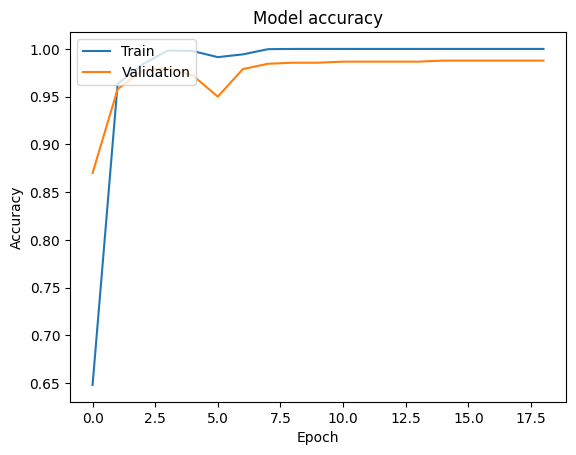

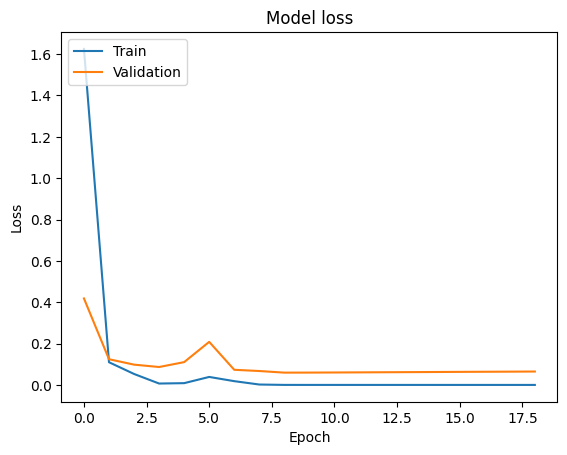

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Confusion Martix

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step
Confusion Matrix:
[[100   0   0   0   0   0   0   0   0]
 [  1  97   0   0   0   0   0   0   2]
 [  0   0  99   0   0   0   0   0   1]
 [  0   0   0 100   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0]
 [  1   0   0   0   0  99   0   0   0]
 [  0   0   0   2   0   0  97   1   0]
 [  1   0   0   0   0   0   1  98   0]
 [  0   1   0   0   1   0   0   0  98]]


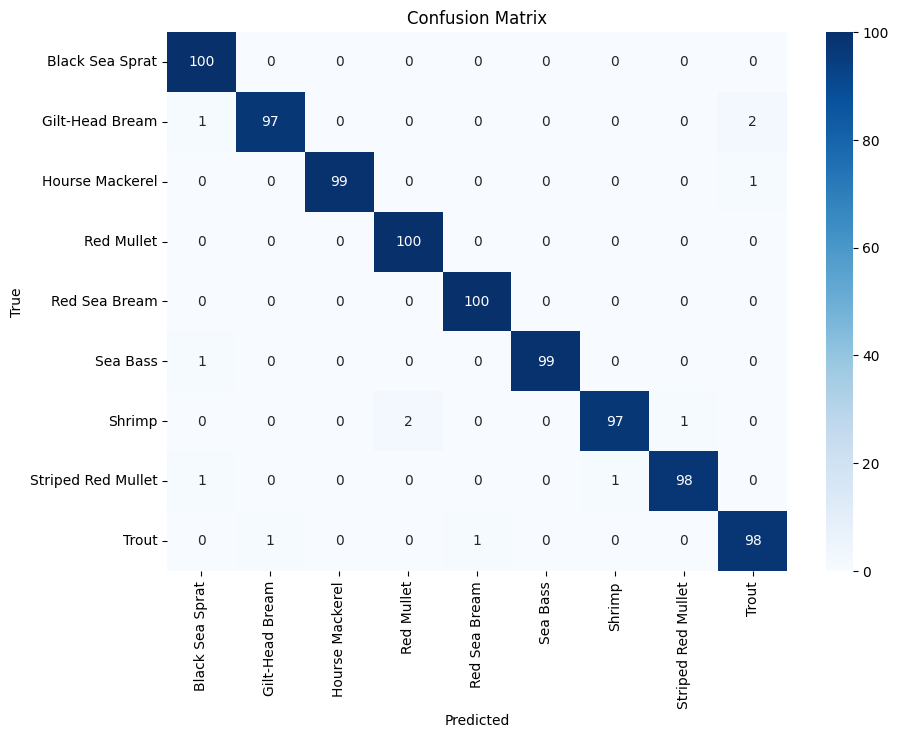

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test or validation set
# Assuming `test_generator` is your test dataset
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels (ground truth)
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
